# ARCH, GARCH and GJR-GARCH Forecasting

__This notebook contains the code that performs the ARCH, GARCH and GJR-GARCH 1-day forecasting for the 1-year CDS-rates__


The notebook is structured as follows:
1. __Loading Dataset, Preprocessing Data__
2. __Stationarity Analysis of Returns and Squared Squared Returns:__
   - Function to look at auto correlation plots of individual companies
3. __Walk-forward forecast implementations of all models:__
   - <u>"model"_forecast</u>, Day ahead forecasting during the 2020 period with parameters fitted in the pre-COVID period (2015-2019).<br>
<span style="color:red">We chose to continue with the 1-Day forecasting method, due to that generally being more aligned with the real world use cases of these models.</span>
4. __Running the models and converting them to .csv files:__

In [1]:
import numpy as np
import os
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
from joblib import Parallel, delayed

## 1. Loading in dataset & Preprocessing

#### (a) Dataset for Credit Default Swap spreads

In [4]:
cds_DF = pd.read_csv("datasets/cds.csv", parse_dates=['Date'])
cds_DF.head()

,Date,Ticker,Company,PX1,PX2,PX3,PX4,PX5,PX6,PX7,PX8,PX9,PX10
0,2015-01-01,A,Agilent Technologies Inc,14.850,25.05,39.055,73.715,86.30,111.305,125.905,144.300,158.600,168.195
1,2015-01-02,A,Agilent Technologies Inc,14.855,25.15,39.160,73.600,86.40,111.510,126.100,144.375,158.775,168.375
2,2015-01-05,A,Agilent Technologies Inc,13.455,24.96,39.310,70.200,88.26,111.970,125.060,143.165,157.385,166.825
3,2015-01-06,A,Agilent Technologies Inc,15.535,24.88,39.300,72.680,91.10,116.610,130.890,150.365,165.655,175.885
4,2015-01-07,A,Agilent Technologies Inc,15.215,25.50,40.270,73.880,92.50,117.780,131.940,151.145,166.215,176.295


#### (b) Processing data
- Creating dictionary with tickers (companies) as keys and as values their respective data from the CDS-dataset.
- Companies that had less than 1747 observations are filtered out, this threshold is chosen, because 1747 represented the typical number of observations for most companies in our dataset. So to exclude potential bias, we filtered the companies with fewer observations
- Companies that had less than 1000 unique observations are also filtered out to ensure enough variability in the data, to perform robust/reliable analysis. 

In [5]:
ticks_DF_dict = {}

for tick in cds_DF.groupby('Ticker').size()[cds_DF.groupby('Ticker').size() >= 1747].index:
    if len(cds_DF[cds_DF['Ticker'] == tick]['PX1'].unique()) > 1000:
        ticks_DF_dict[tick] = cds_DF[cds_DF['Ticker'] == tick].set_index("Date")

## 2. Stationarity Analysis

#### (b) Autocorrelation plots

Used to test the stationarity of the CDS returns data, paying particular attention to the autocorrelation observed in the squared returns, which serves as motivation for the use of our GARCH models. 

In [6]:
def autocorrelation_plotter(dataset, ticker, lagmin=1, lagmax=50, squared=False):

    px_columns = [f'PX{i}' for i in range(1, 11)]

    tickerset = dataset[ticker]

    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 12))
    axes = axes.flatten()

    # iterate over PX columns and plot ACF for each
    for i, col in enumerate(px_columns):
        if col not in tickerset.columns:
            print(f"Column '{col}' not found for ticker '{ticker}'.")
            continue

        price_col = tickerset[col].dropna()

        if not price_col.empty:
            if squared:
                plot_acf(price_col**2, lags=np.arange(lagmin, lagmax), ax=axes[i], title=f"Autocorr: {col}", auto_ylims=True, color='firebrick')
            else:
                plot_acf(price_col, lags=np.arange(lagmin, lagmax), ax=axes[i], title=f"Autocorr: {col}", auto_ylims=True, color='firebrick')

            axes[i].set_xlim(lagmin, lagmax)
            axes[i].set_xlabel("Lags")
            axes[i].set_ylabel("Autocorrelation")
        else:
            axes[i].set_title(f"Autocorr: {col} (No Data)")

    plt.tight_layout()
    plt.suptitle(f"Autocorrelation of CDS Prices for Ticker: {ticker}", fontsize=14, y=1.02)
    plt.show()

In [7]:
def calculate_log_returns(dataset):
    
    px_columns = [f'PX{i}' for i in range(1, 11)]
    returns_dict = {}

    for ticker, df in dataset.items():
        returns_df = df.copy()
        for col in px_columns:
            returns_df[col] = (np.log(df[col]) - np.log(df[col].shift(1))) * 100
        returns_dict[ticker] = returns_df.dropna()

    return returns_dict

In [9]:
cds_returns_dict = calculate_log_returns(ticks_DF_dict)

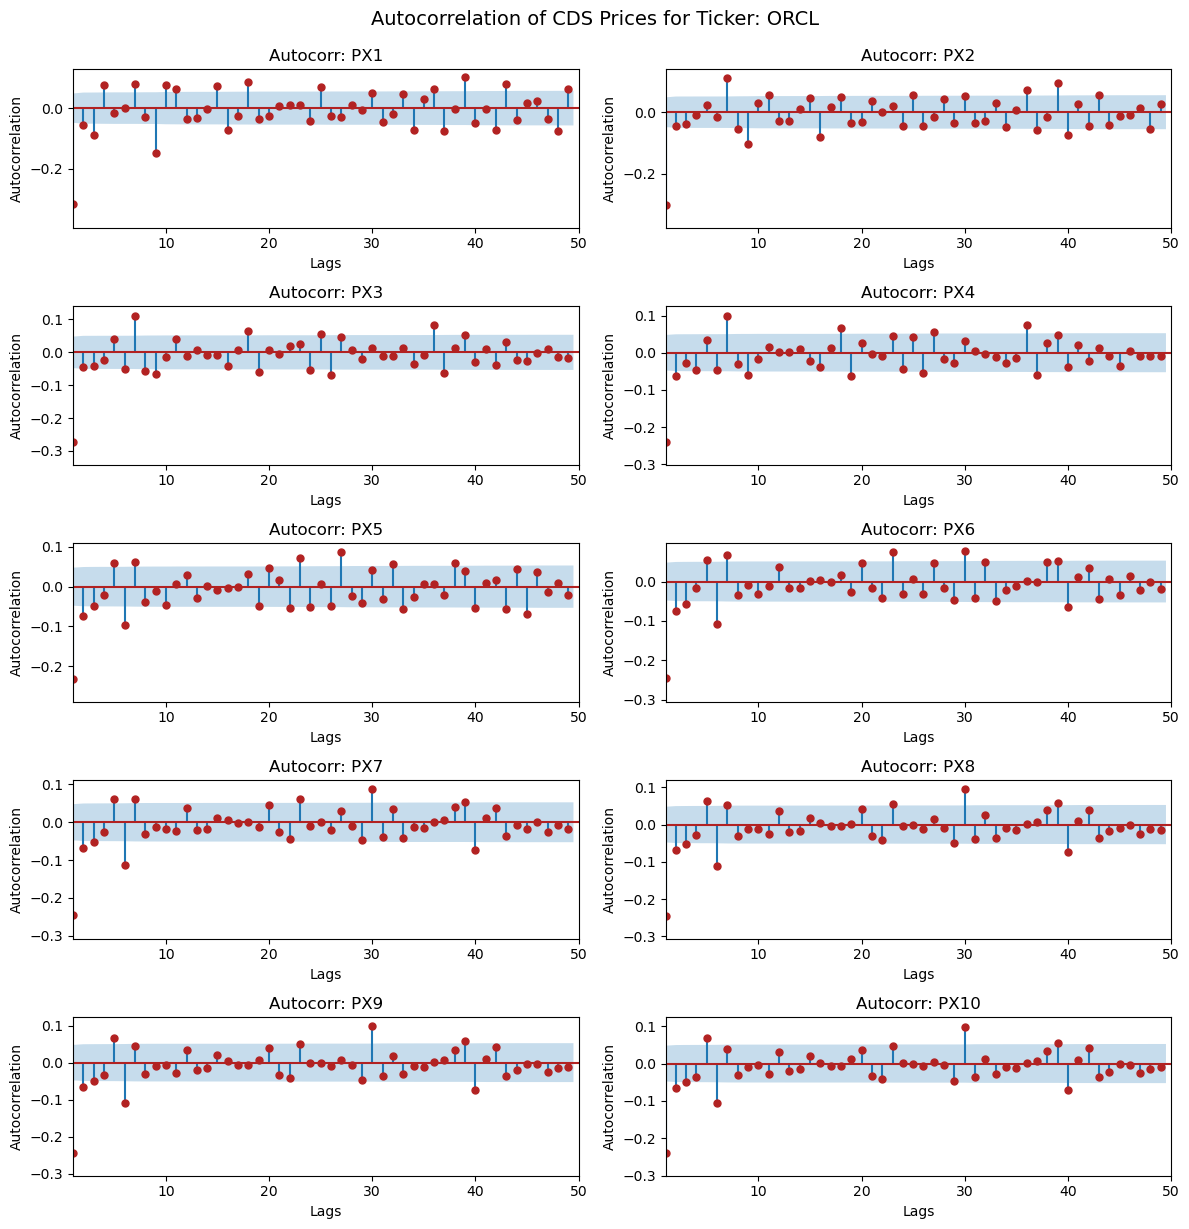

In [12]:
autocorrelation_plotter(cds_returns_dict, 'ORCL')

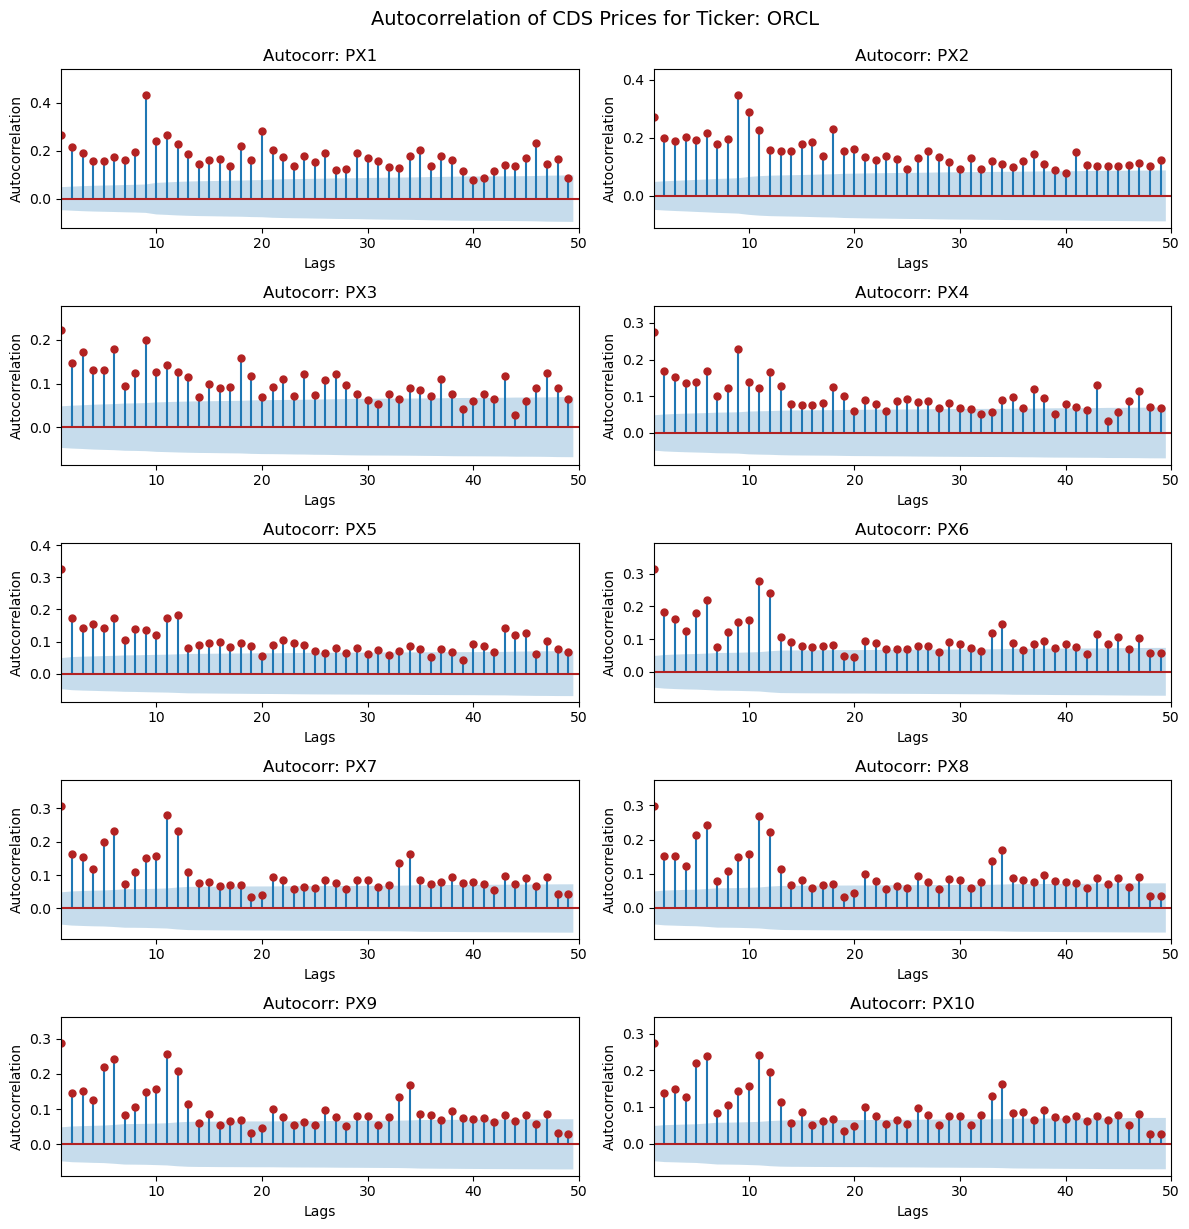

In [13]:
autocorrelation_plotter(cds_returns_dict, 'ORCL', squared=True)

We can see that a GARCH model is appropriate here

Imported Parallel and delayed otherwise this code would take excessively long to run (days)

#### Sidebar

While we ultimately did continue with our optimised lag-order approach due to the desire to maintain a consistent and fair comparison, we decided to keep the code included as it serves as a step for further exploration at a later stage.

In [20]:
def AIC_picker(dataset, max_p=3, max_q=3):
    px_columns = [f'PX{i}' for i in range(1, 11)]    
    results = {}

    for ticker, df in dataset.items():
        results[ticker] = {}
        
        for col in px_columns:
            if col in df.columns:
                subset = df[col].dropna()
                if subset.empty:
                    results[ticker][col] = {'best_p': None, 'best_q': None, 'AIC': None}
                    continue
                
                # parallel fitting of GARCH models
                fit_results = Parallel(n_jobs=-1)(delayed(fit_garch)(subset, p, q) for p in range(1, max_p + 1) for q in range(1, max_q + 1))
                
                best_aic = fit_garch(subset, p=1, q=1)[-1]
                best_order = (1, 1)

                for p, q, aic in fit_results:
                    if aic < best_aic:
                        best_aic = aic
                        best_order = (p, q)

                results[ticker][col] = {'best_p': best_order[0], 'best_q': best_order[1], 'AIC': best_aic}
            else:
                results[ticker][col] = {'best_p': None, 'best_q': None, 'AIC': None}
    
    return results

In [21]:
# aic_values_garch = AIC_picker(cds_diffs_train)

In [22]:
# aic_values_garch = AIC_picker(cds_returns_train)

In [23]:
# aic_values_garch

## 3. ARCH(1), GARCH(1,1) AND GJR-GARCH(1,1,1) day-ahead (walk-forward) forecasting models

In [94]:
def garch_forecast(tDF, test_year, colname='PX1', num_sims=100, plot=False):
    np.random.seed(1)
    
    # compute log returns
    tDF_return = (np.log(tDF[colname]) - np.log(tDF[colname].shift(1))) * 100
    tDF_return = tDF_return.dropna()

    train_set_spread = tDF[tDF.index.year < test_year][colname]
    test_set_spread  = tDF[tDF.index.year == test_year][colname]
    
    # split RETURNS data into train and test sets
    train_set = tDF_return[tDF_return.index.year < test_year]
    test_set = tDF_return[tDF_return.index.year == test_year]
    
    # fit GARCH(1,1) on the train set
    model = arch_model(train_set, p=1, q=1, mean='Constant')
    model_fitted = model.fit(disp="off")
    
    # extract parameters
    mu = model_fitted.params['mu']
    omega = model_fitted.params['omega']
    alpha = model_fitted.params['alpha[1]']
    beta = model_fitted.params['beta[1]']
    last_sigma = model_fitted.conditional_volatility.iloc[-1]
    last_return = train_set.iloc[-1]

    sigmas = []
    shocks = []
    return_forecasts = []
    CI_low = []
    CI_high = []

    # forecast volatilities recursively
    for return_t in test_set:
        # GARCH(1,1) recursion formula
        sigma_squared_next = omega + alpha * (last_return**2) + beta * (last_sigma**2)
        sigma_next = np.sqrt(sigma_squared_next)

        for _ in range(num_sims):
            shock = np.random.normal()
            shocks.append(shock)
        mean_shock = np.mean(shocks)
        
        forecast_return = mu + sigma_next * mean_shock
        
        sigmas.append(sigma_next)
        return_forecasts.append(forecast_return)

        # update for next step
        last_sigma = sigma_next
        last_return = return_t

        lower_ci = mu - 1.96 * sigma_next
        upper_ci = mu + 1.96 * sigma_next

        CI_low.append(lower_ci)
        CI_high.append(upper_ci)        
    
    sigma_series = pd.Series(sigmas, index=test_set.index)
    return_series = pd.Series(return_forecasts, index=test_set.index)

    # reverse-model our returns forecast to obtain day-ahead price forecast 
    price_forecast_series = (1 + return_series/100) * test_set_spread.shift(1)

    CI_ints = []
    for i in range(len(CI_low)):
        CI_low_spread = price_forecast_series.iloc[i] * (1+ CI_low[i]/100)
        CI_high_spread = price_forecast_series.iloc[i] * (1+ CI_high[i]/100)
        CI_ints.append((CI_low_spread, CI_high_spread))


    if plot==True:
        fig = plt.figure(figsize=(12,5))
        plt.plot(test_set_spread.index, test_set_spread.values, color='orange', alpha=0.6, label="Actual Test Data")
        plt.plot(test_set_spread.index, price_forecast_series.values, color='red', alpha=0.6, label="Forecasted Data")
        lower_bounds = [ci[0] for ci in CI_ints]
        upper_bounds = [ci[1] for ci in CI_ints]
        plt.fill_between(test_set_spread.index, lower_bounds, upper_bounds, color='blue', alpha=0.2, label="95% CI-interval")
        fig.autofmt_xdate(rotation=45)
        plt.xlabel("Year")
        plt.ylabel("CDS-spread")
        plt.title(f"GARCH(1,1) Walk-Forward Forecast for {tDF.Company.iloc[0]} in {test_year}")
        plt.legend()
        plt.show()

    result_frame = pd.DataFrame({
        'date': test_set_spread.index,
        'actual': test_set_spread.values,
        'preds': price_forecast_series.values,
        'lower_95': [ci[0] for ci in CI_ints],
        'upper_95': [ci[1] for ci in CI_ints]
    })


    return result_frame

In [105]:
def ARCH_forecast(tDF, test_year, colname='PX1', num_sims=100, plot=False):
    np.random.seed(1)
    
    # compute log returns
    tDF_return = (np.log(tDF[colname]) - np.log(tDF[colname].shift(1))) * 100
    tDF_return = tDF_return.dropna()

    train_set_spread = tDF[tDF.index.year < test_year][colname]
    test_set_spread  = tDF[tDF.index.year == test_year][colname]
    
    # split RETURNS into train and test sets
    train_set = tDF_return[tDF_return.index.year < test_year]
    test_set = tDF_return[tDF_return.index.year == test_year]
    
    # fit ARCH(1) model on the train set
    model = arch_model(train_set, p=1, q=0, mean='Constant')  # q=0 for ARCH
    model_fitted = model.fit(disp="off")
    
    # extract parameters
    mu = model_fitted.params['mu']
    omega = model_fitted.params['omega']
    alpha = model_fitted.params['alpha[1]']
    last_sigma = model_fitted.conditional_volatility.iloc[-1]
    last_return = train_set.iloc[-1]

    sigmas = []
    shocks = []
    return_forecasts = []
    CI_low = []
    CI_high = []

    # forecast volatilities recursively
    for return_t in test_set:
        # ARCH(1) recursion formula
        sigma_squared_next = omega + alpha * (last_return**2)
        sigma_next = np.sqrt(sigma_squared_next)

        for _ in range(num_sims):
            shock = np.random.normal()
            shocks.append(shock)
        mean_shock = np.mean(shocks)
        
        forecast_return = mu + sigma_next * mean_shock
        
        sigmas.append(sigma_next)
        return_forecasts.append(forecast_return)

        # update for next step
        last_sigma = sigma_next
        last_return = return_t

        lower_ci = mu - 1.96 * sigma_next
        upper_ci = mu + 1.96 * sigma_next

        CI_low.append(lower_ci)
        CI_high.append(upper_ci)        

    sigma_series = pd.Series(sigmas, index=test_set.index)
    return_series = pd.Series(return_forecasts, index=test_set.index)

    # reverse-model our returns forecast to obtain day-ahead price forecast
    price_forecast_series = (1 + return_series/100) * test_set_spread.shift(1)

    CI_ints = []
    for i in range(len(CI_low)):
        CI_low_spread = price_forecast_series.iloc[i] * (1+ CI_low[i]/100)
        CI_high_spread = price_forecast_series.iloc[i] * (1+ CI_high[i]/100)
        CI_ints.append((CI_low_spread, CI_high_spread))

    if plot==True:
        fig = plt.figure(figsize=(12,5))
        plt.plot(test_set_spread.index, test_set_spread.values, color='orange', alpha=0.6, label="Actual Test Data")
        plt.plot(test_set_spread.index, price_forecast_series.values, color='red', alpha=0.6, label="Forecasted Data")
        lower_bounds = [ci[0] for ci in CI_ints]
        upper_bounds = [ci[1] for ci in CI_ints]
        plt.fill_between(test_set_spread.index, lower_bounds, upper_bounds, color='blue', alpha=0.2, label="95% CI-interval")
        fig.autofmt_xdate(rotation=45)
        plt.xlabel("Year")
        plt.ylabel("CDS-spread")
        plt.title(f"ARCH(1) Walk-Forward Forecast for {tDF.Company.iloc[0]} in {test_year}")
        plt.legend()
        plt.show()

    result_frame = pd.DataFrame({
        'date': test_set_spread.index,
        'actual': test_set_spread.values,
        'preds': price_forecast_series.values,
        'lower_95': [ci[0] for ci in CI_ints],
        'upper_95': [ci[1] for ci in CI_ints]
    })

    return result_frame

In [110]:
def GJR_GARCH_forecast(tDF, test_year, colname='PX1', num_sims=100, plot=False):
    np.random.seed(1)
    
    # compute log returns
    tDF_return = (np.log(tDF[colname]) - np.log(tDF[colname].shift(1))) * 100
    tDF_return = tDF_return.dropna()

    train_set_spread = tDF[tDF.index.year < test_year][colname]
    test_set_spread  = tDF[tDF.index.year == test_year][colname]
    
    # split returns data into train and test sets
    train_set = tDF_return[tDF_return.index.year < test_year]
    test_set = tDF_return[tDF_return.index.year == test_year]
    
    # Fit GJR-GARCH(1,1) model on the train set
    model = arch_model(train_set, p=1, o=1, q=1, mean='Constant')  # GJR-GARCH: o=1 (asymmetry term - "leverage effect")
    model_fitted = model.fit(disp="off")
    
    # extract parameters
    mu = model_fitted.params['mu']
    omega = model_fitted.params['omega']
    alpha = model_fitted.params['alpha[1]']
    gamma = model_fitted.params['gamma[1]']
    beta = model_fitted.params['beta[1]']
    last_sigma = model_fitted.conditional_volatility.iloc[-1]
    last_return = train_set.iloc[-1]

    sigmas = []
    shocks = []
    return_forecasts = []
    CI_low = []
    CI_high = []

    # forecast volatilities recursively
    for return_t in test_set:
        # GJR-GARCH recursion formula
        indicator = 1 if return_t < 0 else 0  # asymmetry indicator
        sigma_squared_next = omega + alpha * (last_return**2) + gamma * indicator * (last_return**2) + beta * (last_sigma**2)
        sigma_next = np.sqrt(sigma_squared_next)

        for _ in range(num_sims):
            shock = np.random.normal()
            shocks.append(shock)
        mean_shock = np.mean(shocks)
        
        forecast_return = mu + sigma_next * mean_shock
        
        sigmas.append(sigma_next)
        return_forecasts.append(forecast_return)

        # update for next step
        last_sigma = sigma_next
        last_return = return_t

        lower_ci = mu - 1.96 * sigma_next
        upper_ci = mu + 1.96 * sigma_next

        CI_low.append(lower_ci)
        CI_high.append(upper_ci)        

    sigma_series = pd.Series(sigmas, index=test_set.index)
    return_series = pd.Series(return_forecasts, index=test_set.index)

    # reverse-model our returns forecast to obtain day-ahead price forecast
    price_forecast_series = (1 + return_series/100) * test_set_spread.shift(1)

    CI_ints = []
    for i in range(len(CI_low)):
        CI_low_spread = price_forecast_series.iloc[i] * (1+ CI_low[i]/100)
        CI_high_spread = price_forecast_series.iloc[i] * (1+ CI_high[i]/100)
        CI_ints.append((CI_low_spread, CI_high_spread))

    if plot==True:
        fig = plt.figure(figsize=(12,5))
        plt.plot(test_set_spread.index, test_set_spread.values, color='orange', alpha=0.6, label="Actual Test Data")
        plt.plot(test_set_spread.index, price_forecast_series.values, color='red', alpha=0.6, label="Forecasted Data")
        lower_bounds = [ci[0] for ci in CI_ints]
        upper_bounds = [ci[1] for ci in CI_ints]
        plt.fill_between(test_set_spread.index, lower_bounds, upper_bounds, color='blue', alpha=0.2, label="95% CI-interval")
        fig.autofmt_xdate(rotation=45)
        plt.xlabel("Year")
        plt.ylabel("CDS-spread")
        plt.title(f"GJR-GARCH(1,1) Walk-Forward Forecast for {tDF.Company.iloc[0]} in {test_year}")
        plt.legend()
        plt.show()

    result_frame = pd.DataFrame({
        'date': test_set_spread.index,
        'actual': test_set_spread.values,
        'preds': price_forecast_series.values,
        'lower_95': [ci[0] for ci in CI_ints],
        'upper_95': [ci[1] for ci in CI_ints]
    })

    return result_frame

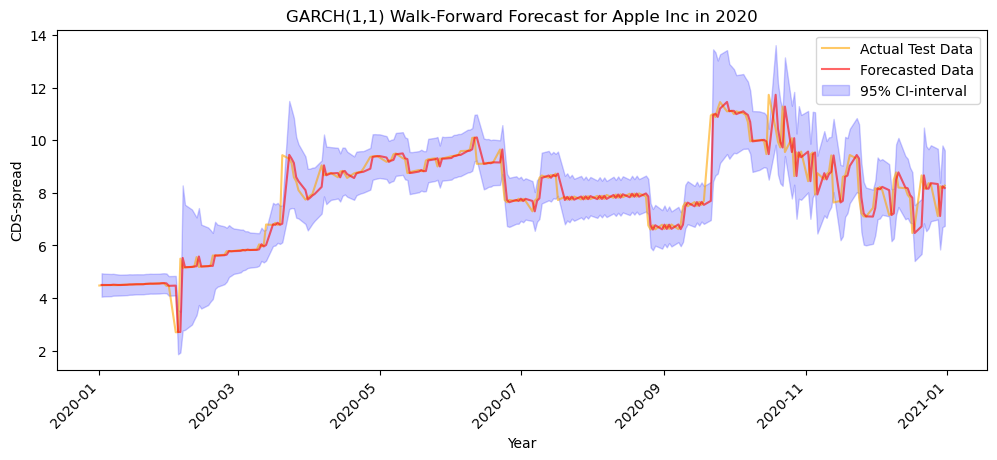

,date,actual,preds,lower_95,upper_95
0,2020-01-01,4.4779,NaN,NaN,NaN
1,2020-01-02,4.4842,4.499935,4.052587,4.943097
2,2020-01-03,4.4872,4.498521,4.062831,4.930026
3,2020-01-06,4.5001,4.496047,4.070488,4.917424
4,2020-01-07,4.4918,4.509334,4.090937,4.923535
...,...,...,...,...,...
257,2020-12-25,8.3362,8.371753,6.923046,9.812672
258,2020-12-28,7.1190,8.336971,6.987856,9.678330
259,2020-12-29,8.2532,7.120076,5.848082,8.385448
260,2020-12-30,8.1845,8.255113,6.697084,9.805462


In [108]:
garch_forecast(ticks_DF_dict['AAPL'], 2020, plot=True)

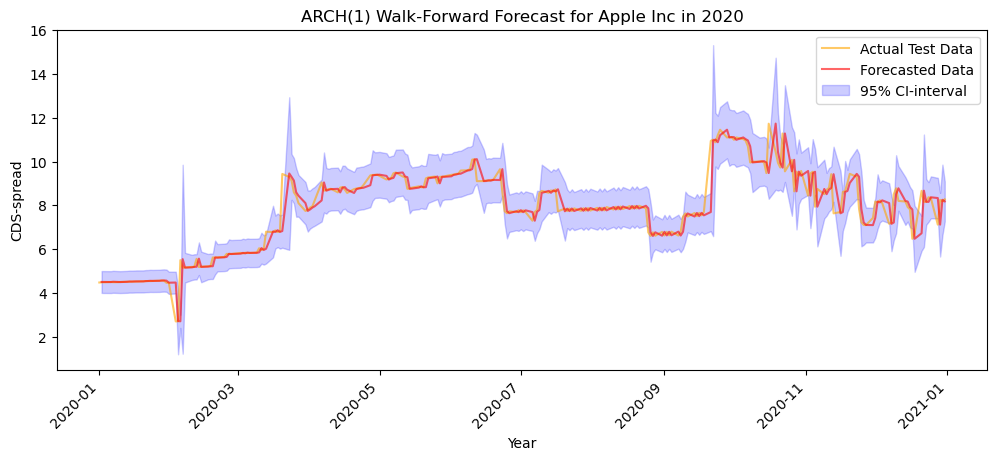

,date,actual,preds,lower_95,upper_95
0,2020-01-01,4.4779,NaN,NaN,NaN
1,2020-01-02,4.4842,4.502884,4.000406,5.001135
2,2020-01-03,4.4872,4.501011,3.998719,4.999079
3,2020-01-06,4.5001,4.497994,3.996075,4.995692
4,2020-01-07,4.4918,4.511626,4.008000,5.011018
...,...,...,...,...,...
257,2020-12-25,8.3362,8.369953,7.407594,9.324456
258,2020-12-28,7.1190,8.335491,7.404636,9.258523
259,2020-12-29,8.2532,7.120685,5.663943,8.570744
260,2020-12-30,8.1845,8.255287,6.640854,9.861971


In [109]:
ARCH_forecast(ticks_DF_dict['AAPL'], 2020, plot=True)

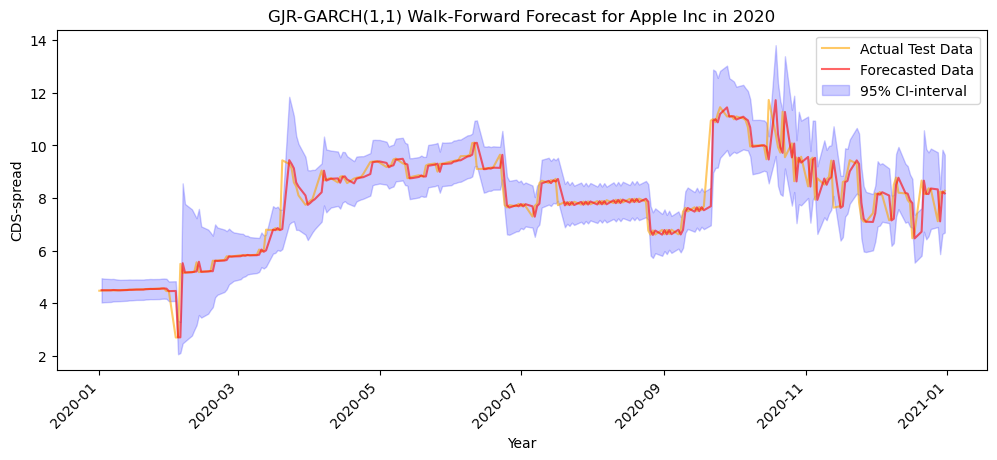

,date,actual,preds,lower_95,upper_95
0,2020-01-01,4.4779,NaN,NaN,NaN
1,2020-01-02,4.4842,4.496950,4.029795,4.952160
2,2020-01-03,4.4872,4.495196,4.041546,4.936906
3,2020-01-06,4.5001,4.492506,4.050578,4.922502
4,2020-01-07,4.4918,4.505764,4.072270,4.927290
...,...,...,...,...,...
257,2020-12-25,8.3362,8.364839,6.824861,9.882598
258,2020-12-28,7.1190,8.330039,6.898914,9.739038
259,2020-12-29,8.2532,7.113824,5.868165,8.340587
260,2020-12-30,8.1845,8.248172,6.635327,9.839108


In [112]:
GJR_GARCH_forecast(ticks_DF_dict['AAPL'], 2020, plot=True)

## 4. Running the models and converting them to .csv files:

#### (a) Running models
- Usage of joblib library for parallel computing, due to long computation time of running al models in just native python

In [116]:
def parallel_walkforward_garch(tDF_dict, test_year, colname, num_sims):
    """ Parallelized Walk-Forward GARCH fitting and forecasting for multiple tickers. """
    results = Parallel(n_jobs=-1)(delayed(garch_forecast)(tDF, test_year, colname, num_sims=100, plot=False) for tick, tDF in tDF_dict.items())

    return {tick: frame for tick, frame in zip(tDF_dict.keys(), results)}

In [117]:
def parallel_walkforward_arch(tDF_dict, test_year, colname, num_sims):
    """ Parallelized Walk-Forward GARCH fitting and forecasting for multiple tickers. """
    results = Parallel(n_jobs=-1)(delayed(ARCH_forecast)(tDF, test_year, colname, num_sims=100, plot=False) for tick, tDF in tDF_dict.items())

    return {tick: frame for tick, frame in zip(tDF_dict.keys(), results)}

In [118]:
def parallel_walkforward_gjr_garch(tDF_dict, test_year, colname, num_sims):
    """ Parallelized Walk-Forward GARCH fitting and forecasting for multiple tickers. """
    results = Parallel(n_jobs=-1)(delayed(GJR_GARCH_forecast)(tDF, test_year, colname, num_sims=100, plot=False) for tick, tDF in tDF_dict.items())

    return {tick: frame for tick, frame in zip(tDF_dict.keys(), results)}

In [119]:
GARCH_tDF_dict = parallel_walkforward_garch(ticks_DF_dict, 2020, "PX1", 100)
ARCH_tDF_dict = parallel_walkforward_arch(ticks_DF_dict, 2020, "PX1", 100)
GJR_GARCH_tDF_dict = parallel_walkforward_gjr_garch(ticks_DF_dict, 2020, "PX1", 100)

#### (b) Converting model results to panel data and storing them in .csv files:

In [120]:
def createPanelDataframe(model_tDF_dict):
    for tick, DF in model_tDF_dict.items():
        DF['tick'] = tick
        if not 'panelDF' in locals():
            panelDF = DF
        else:
            panelDF = pd.concat([panelDF, DF])
    return panelDF.reset_index(drop=True)

In [123]:
panel_GARCH = createPanelDataframe(GARCH_tDF_dict).dropna()
panel_ARCH = createPanelDataframe(ARCH_tDF_dict).dropna()
panel_GJR_GARCH = createPanelDataframe(GJR_GARCH_tDF_dict).dropna()

In [124]:
panel_GARCH.to_csv('datasets/GARCH/GARCH_forecast.csv')
panel_ARCH.to_csv('datasets/ARCH/ARCH_forecast.csv')
panel_GJR_GARCH.to_csv('datasets/GJR_GARCH/GJR_GARCH_forecast.csv')